In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
from sklearn.decomposition import PCA

np.set_printoptions(linewidth=200)
matplotlib_color_order = plt.rcParams['axes.prop_cycle'].by_key()['color']

# %matplotlib widget
%matplotlib inline

## Visualize Robot Movements

In [2]:
train_data_directory = "data/train/"
test_data_directory = "data/test/"

def get_file_path(movement: str, number: int, train: bool = True) -> str:
    if train:
        filepath = os.path.join(train_data_directory, f"{movement}_{number}.npy")
    else: 
        filepath = os.path.join(test_data_directory, f"{movement}_{number}t.npy")
    return filepath

In [3]:
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# ax.plot(data[:,:,0][:,0], data[:,:,0][:,1], data[:,:,0][:,2], 'o')
# plt.show()


In [4]:
def animate_movement(filepath: str) -> animation.FuncAnimation:
    """Animate the movement of the robot given the file path to the data"""

    data = np.load(filepath)
    data = data.reshape(38,3,100)
    animation.writer = animation.writers['ffmpeg']

    plt.ioff()
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # write the update function, specifically including the ax.clear() function this was important.
    def update(i):
        ax.clear()
        ax.plot(data[:,:,i][:,0], data[:,:,i][:,1], data[:,:,i][:,2], 'o-', markersize=2)
        ax.set_title("Robot Movement Visualization")
        ax.set_xlim(-750, 1000)
        ax.set_ylim(-1000, 1000)
        ax.set_zlim(-750, 1000)
        return ax

    ani = animation.FuncAnimation(fig, update, frames=range(100), interval=25)

    return ani

In [5]:
# filepath = get_file_path("walking", 1)
# ani = animate_movement(filepath=filepath)
# HTML(ani.to_html5_video())

## Load Data

In [6]:
who

HTML	 PCA	 animate_movement	 animation	 get_file_path	 matplotlib_color_order	 np	 os	 plt	 
test_data_directory	 train_data_directory	 


In [7]:
num_train_samples = 5
num_test_samples = 1
num_frames_per_sample = 100

def load_movement_data(train: bool = True) -> tuple[np.array, np.array]:
    """Load all the training or test data into a single numpy array"""
    num_samples = num_train_samples if train else num_test_samples

    data_loaded = []
    labels = []
    movements = ["jumping", "running", "walking"]
    for movement in movements:
        for i in range(1, num_samples + 1):
            filepath = get_file_path(movement, i, train=train)
            data_loaded.append(np.load(filepath))

            # Append the movement repeatedly for each frame in the sample.
            labels += [movement] * num_frames_per_sample

    all_samples = np.hstack(data_loaded)
    labels = np.array(labels)

    # transpose data so samples are the rows and features are the columns as expected by sklearn PCA
    return all_samples.T, labels

# movement_data_train, labels = load_movement_data(train=True)

## PCA on Robot Movement Samples

In [8]:
def pca_plotting_helper(
    data_transformed: np.array,
    k_components: int,
    labels: np.array
) -> None:
    """Plot the transformed data in 2D or 3D"""
    if k_components == 2:
        fig = plt.figure()
        ax = fig.add_subplot(111)

        for i, label in enumerate(np.unique(labels)):
            ax.scatter(
                data_transformed[labels == label, 0],
                data_transformed[labels == label, 1],
                label=label
            )
        ax.set_xlabel("PC1")
        ax.set_ylabel("PC2")

    elif k_components == 3:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        for i, label in enumerate(np.unique(labels)):
            ax.scatter(
                data_transformed[labels == label, 0],
                data_transformed[labels == label, 1],
                data_transformed[labels == label, 2],
                label=label
            )
        # TODO: Adjust the init view in the future
        ax.view_init(azim=45)
        ax.set_xlabel("PC1")
        ax.set_ylabel("PC2")
        ax.set_zlabel("PC3")
    
    else:
        raise ValueError(f"Only 2 or 3 components can be plotted, however {k_components} were given.")

    plt.legend()
    plt.show()


def fit_k_component_pca(
    data: np.array,
    labels: np.array,
    k_components: int = 2,
    plot: bool = True
) -> PCA:
    """Fit a PCA model to the data and plot the transformed data"""
    my_pca_model = PCA(n_components=k_components)
    my_pca_model.fit(data)
    data_transformed = my_pca_model.transform(data)

    if plot:
        pca_plotting_helper(data_transformed, k_components, labels)  

    return my_pca_model

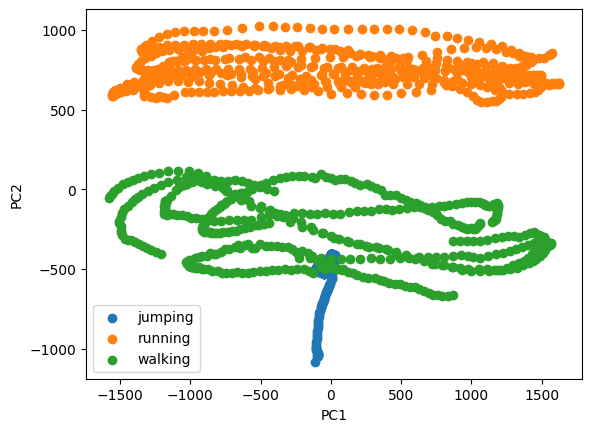

In [9]:
movement_data_train, labels = load_movement_data(train=True)
pca_model_2 = fit_k_component_pca(movement_data_train, labels, k_components=2)

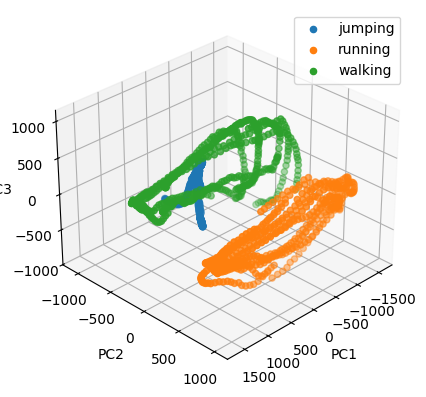

In [10]:
pca_model_2 = fit_k_component_pca(movement_data_train, labels, k_components=3)

In [11]:
# compute mean of each label after performing PCA
# reclassify each point based on min distance from mean of each label
# compute accuracy

ORDER_OF_NORM = 2

from sklearn.base import BaseEstimator, ClassifierMixin

class CustomDistanceClassifier(ClassifierMixin, BaseEstimator):
    def __init__(self) -> None:
        pass

    def fit(self, X: np.array, y: np.array) -> "CustomDistanceClassifier":
        """Compute the means of each label."""
        self.labels = np.unique(y)
        self.means = np.array(
            [ X[y == label].mean(axis=0) for label in self.labels ]
        )
        return self
    
    def predict(self, X):
        """Compute distance of points in X from each mean."""
        distances = np.array(
            [ np.linalg.norm(X - mean, ord=ORDER_OF_NORM, axis=1) for mean in self.means ]
        )
        index_of_min_distance = np.argmin(distances, axis=0)
        return self.labels[index_of_min_distance]


In [20]:
movement_data_train_transformed = pca_model_2.transform(movement_data_train)

In [21]:
myclassifier = CustomDistanceClassifier()
myclassifier.fit(movement_data_train_transformed, labels)

predicted_labels = myclassifier.predict(movement_data_train_transformed)

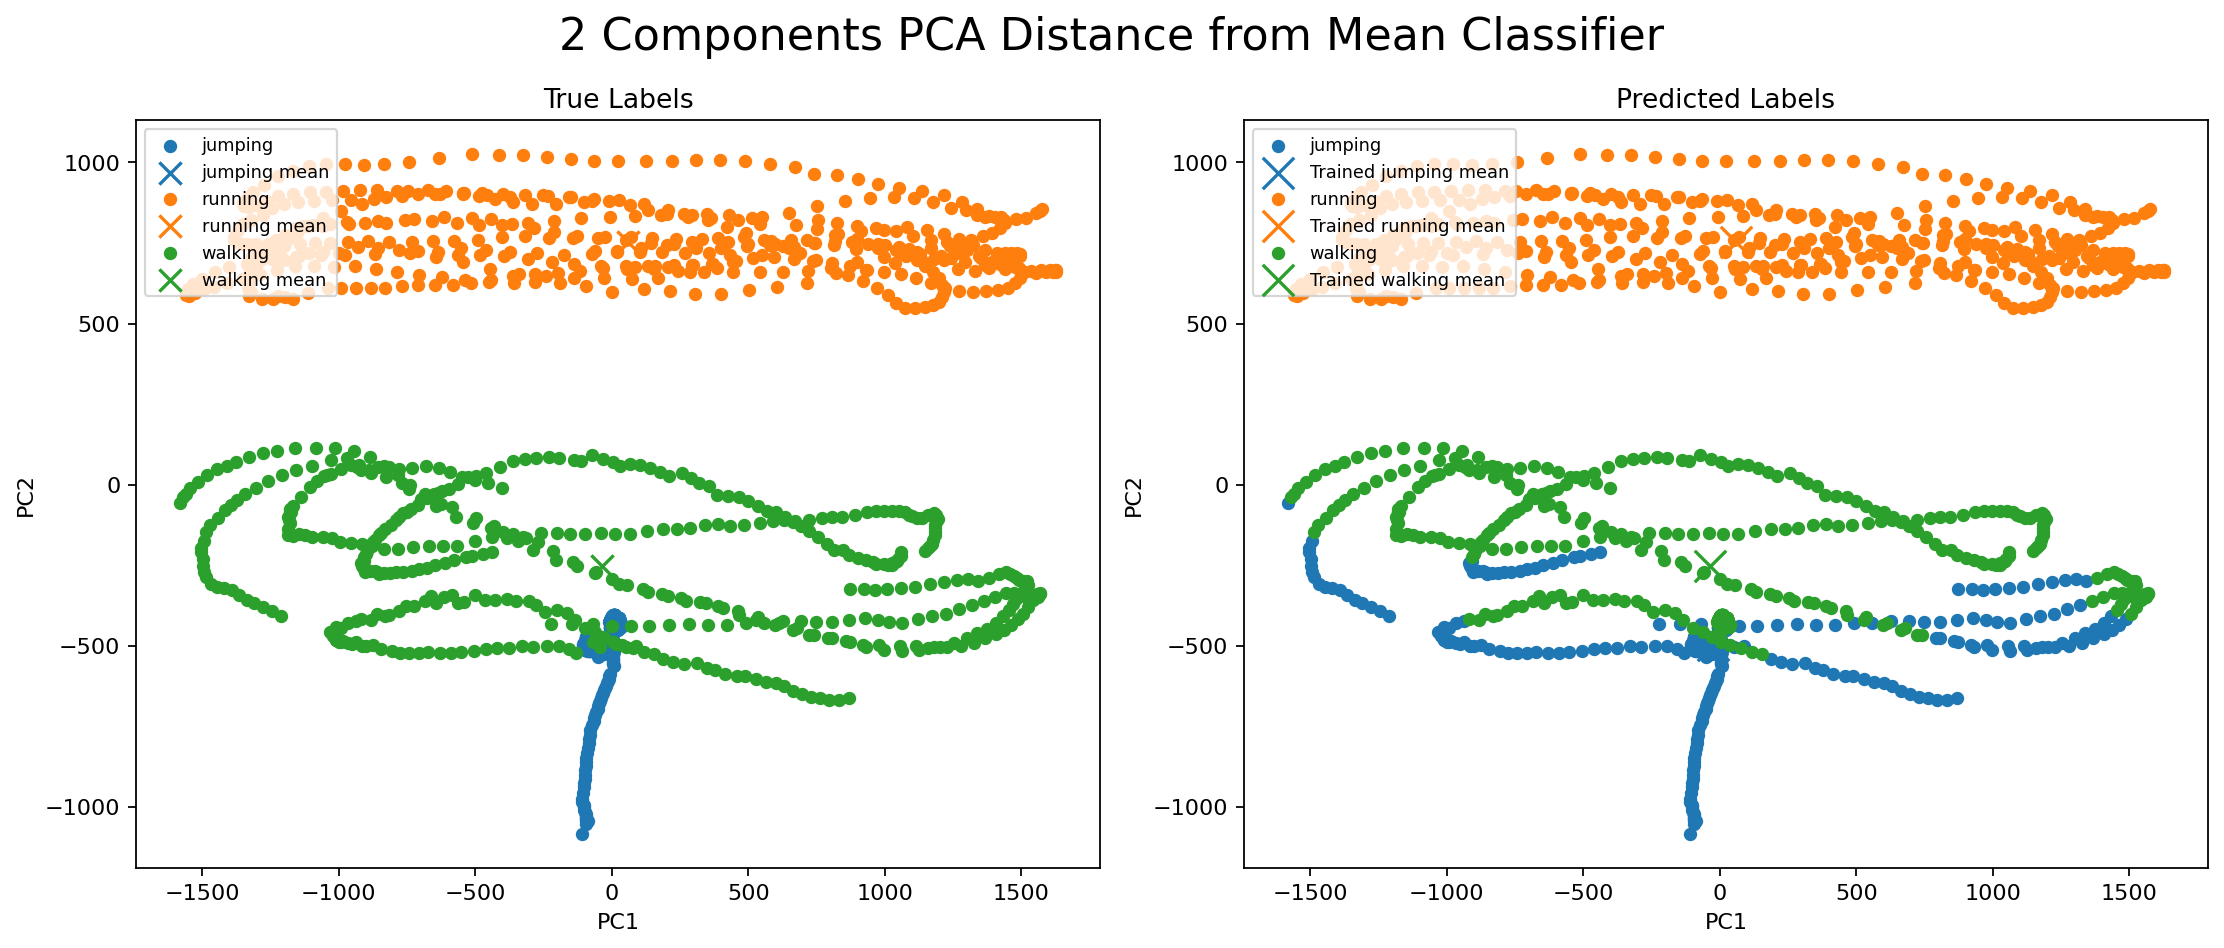

In [22]:
fig = plt.figure(figsize=(14, 6), dpi=160)
ax0 = fig.add_subplot(121)

for i, label in enumerate(np.unique(labels)):
    ax0.scatter(
        movement_data_train_transformed[labels == label, 0],
        movement_data_train_transformed[labels == label, 1],
        label=label,
        color=matplotlib_color_order[i],
        s=25,
    )
    ax0.scatter(myclassifier.means[i, 0], myclassifier.means[i, 1], s=100, label=f"{label} mean", color=matplotlib_color_order[i], marker="x")

ax0.set_xlabel("PC1")
ax0.set_ylabel("PC2")
ax0.legend(loc='upper left', fontsize=8)
ax0.set_title("True Labels")

ax1 = fig.add_subplot(122)

for i, label in enumerate(np.unique(predicted_labels)):
    ax1.scatter(
        movement_data_train_transformed[predicted_labels == label, 0],
        movement_data_train_transformed[predicted_labels == label, 1],
        label=label,
        color=matplotlib_color_order[i],
        s=25,
    )
    ax1.scatter(myclassifier.means[i, 0], myclassifier.means[i, 1], s=200, label=f"Trained {label} mean", color=matplotlib_color_order[i], marker="x")

ax1.set_xlabel("PC1")
ax1.set_ylabel("PC2")
ax1.legend(loc='upper left', fontsize=8)
ax1.set_title("Predicted Labels")


plt.suptitle("2 Components PCA Distance from Mean Classifier", fontsize=20)
plt.tight_layout()
plt.show()

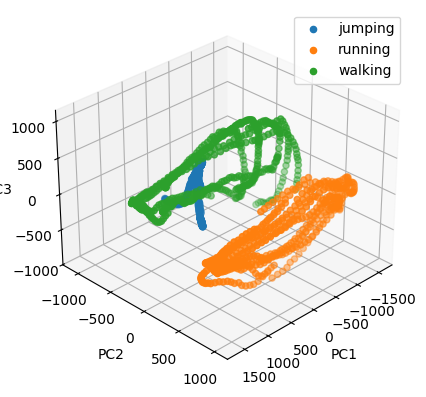

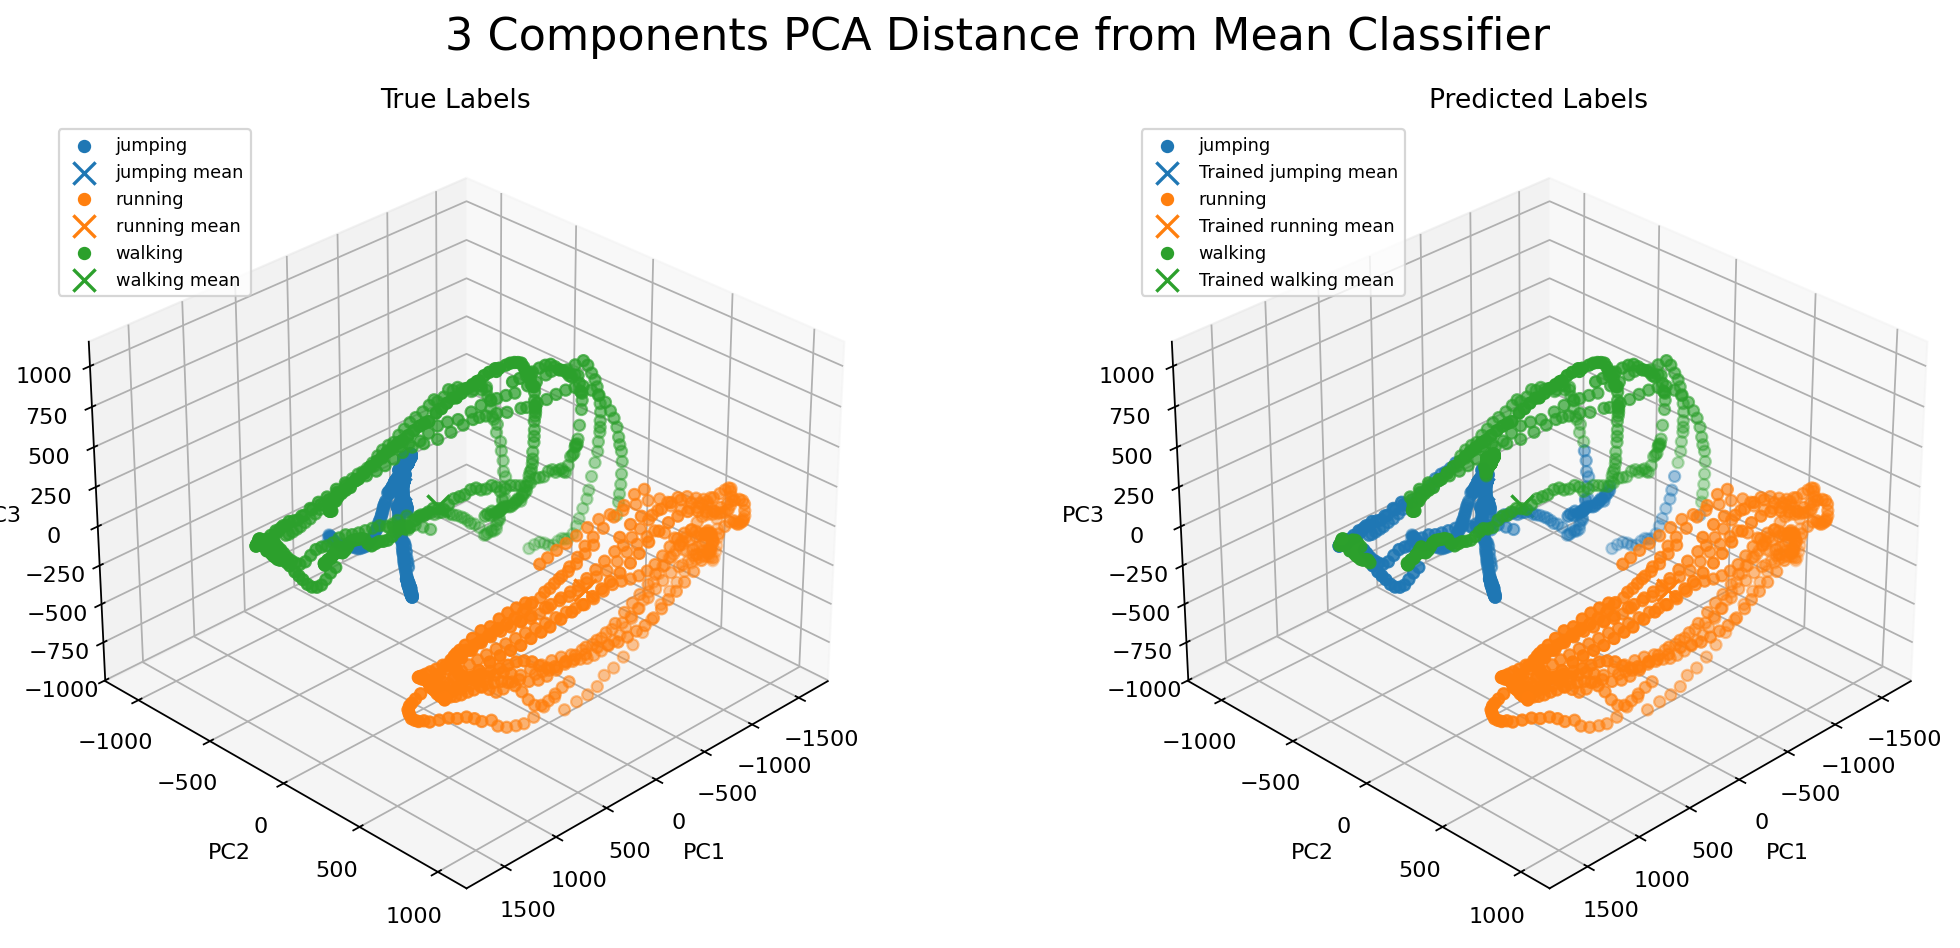

In [15]:
movement_data_train, labels = load_movement_data(train=True)
pca_model_3 = fit_k_component_pca(movement_data_train, labels, k_components=3)

movement_data_train_transformed = pca_model_3.transform(movement_data_train)

myclassifier = CustomDistanceClassifier()
myclassifier.fit(movement_data_train_transformed, labels)

predicted_labels = myclassifier.predict(movement_data_train_transformed)

fig = plt.figure(figsize=(14, 6), dpi=160)
ax0 = fig.add_subplot(121, projection='3d')

for i, label in enumerate(np.unique(labels)):
    ax0.scatter(
        movement_data_train_transformed[labels == label, 0],
        movement_data_train_transformed[labels == label, 1],
        movement_data_train_transformed[labels == label, 2],
        label=label,
        color=matplotlib_color_order[i],
        s=25,
    )
    ax0.scatter(myclassifier.means[i, 0], myclassifier.means[i, 1], s=100, label=f"{label} mean", color=matplotlib_color_order[i], marker="x")

ax0.view_init(azim=45)
ax0.set_xlabel("PC1")
ax0.set_ylabel("PC2")
ax0.set_zlabel("PC3")
ax0.legend(loc='upper left', fontsize=8)
ax0.set_title("True Labels")

ax1 = fig.add_subplot(122, projection='3d')

for i, label in enumerate(np.unique(predicted_labels)):
    ax1.scatter(
        movement_data_train_transformed[predicted_labels == label, 0],
        movement_data_train_transformed[predicted_labels == label, 1],
        movement_data_train_transformed[predicted_labels == label, 2],
        label=label,
        color=matplotlib_color_order[i],
        s=25,
    )
    ax1.scatter(myclassifier.means[i, 0], myclassifier.means[i, 1], s=100, label=f"Trained {label} mean", color=matplotlib_color_order[i], marker="x")

ax1.view_init(azim=45)
ax1.set_xlabel("PC1")
ax1.set_ylabel("PC2")
ax1.set_zlabel("PC3")
ax1.legend(loc='upper left', fontsize=8)
ax1.set_title("Predicted Labels")


plt.suptitle("3 Components PCA Distance from Mean Classifier", fontsize=20)
plt.tight_layout()
plt.show()

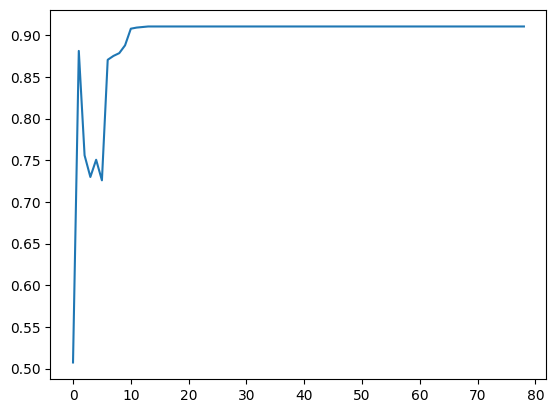

In [16]:
scores = []
predicted_labels = []

for k in range(1,80):
    pca_model = PCA(n_components=k)
    movement_data_train_transformed = pca_model.fit_transform(movement_data_train)
        
    clasif_model = CustomDistanceClassifier()
    clasif_model.fit(movement_data_train_transformed, labels)
    scores.append(clasif_model.score(movement_data_train_transformed, labels))
    predicted_labels.append(clasif_model.predict(movement_data_train_transformed))

fig = plt.figure()

ax = fig.add_subplot(111)

ax.plot(np.array(scores))
plt.show()

In [17]:
for k, predicted_label in enumerate(predicted_labels):
    for i in range(len(labels)):
        if predicted_label[i] == labels[i]:
            continue
        # else:
            # print(f"With {k+1:02} components, sample point {i+1:02} was predicted as {predicted_label[i]} but was actually {labels[i]}")
# print(f"k_modes: {k}", clasif_model.predict(movement_data_train_transformed))

In [18]:
# TODO: Next I want to plot the original training data and their means with the predicted labels of the test set